# Comparing memory, memory + stimuli , stimuli driven
original parameters fitted to my data, including H1

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from numba import jit
from matplotlib_scalebar.scalebar import ScaleBar
path_figs = 'Figs/'

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.3
memory_drift_adaptive_coef = 0
visual_drift_adaptive_coef = 0
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9

In [94]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result



In [95]:
def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [96]:
# seq = '13524232514111'
# specific_seq = '13524232514111'
# random_seq = '45341323141322'
# specific_seq_changed = '13524223141322'
# specific_seq_changed_one_digit = '13524212514111'

seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'


seq_length = len(seq)

window_sizes = [1,2,3,4,11]
# window_sizes = [2,3,4,11]


visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 90
motor_delay = 50

diffusion = 2
threshold = 350
alpha = 0.9985
beta = 0.0005



param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]


# motor_planning_param = [0.54899844, 0.3728446 , 0.32852511]
# motor_planning_param = [0.7527961,  0.78437558, 0.16115195]
motor_planning_param = [1, 1, 0]

In [97]:
visual_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [98]:
memory_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [99]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")


@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

In [85]:
@jit(nopython=True)
def exp_motor_planning(capacity, param):
    theta = np.zeros(capacity)
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = 1 - theta[0]
    elif capacity >= 3:
        theta[0] = param[1]
        theta[1] = param[2]
        theta[2] = 1 - theta[0] - theta[1]
    # elif capacity >= 4:
    #     theta[0] = param[3]
    #     theta[1] = param[4]
    #     theta[2] = param[5]
    #     theta[3] = 1 - theta[0] - theta[1] - theta[2]
        
    return theta

In [86]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

In [87]:
def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

In [88]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, motor_planning_param , planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef,
                 visual_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    effective_planning_capacity_motor = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
    motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef

        for press in range(current_press_planned, min(seq_length, current_press_planned + effective_planning_capacity_motor)):
            evidence[:, press] += motor_planning_coefs[press - current_press_planned] * drifts_memory_dt[:, press] * current_memory_coef
            

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            


        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            visible_window_size = max(0, visible_window_size)
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




    return press_times, evidence

In [89]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3, motor_planning_param = 3, 
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7,
                 visual_drift_coef = visual_drift_coef): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.motor_planning_param = motor_planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drifts_coef = memory_drift_coef
        self.visual_drift_coef = visual_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, self.motor_planning_param,
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drifts_coef,
                                              self.visual_drift_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        motor_planning_coefs = planning_coefs / sum(planning_coefs)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)
        # visual_delay_passed = False

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt
            # current_press_time += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    # evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence[finger, press] += motor_planning_coefs[press - current_press_planned] * self.memory_drifts[finger, press] * self.dt * current_memory_coef
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                # if press == current_press_planned:
                #         for finger in range(5):
                #             evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                #             evidence_over_time[finger, current_press_planned, t_index] = evidence[finger, current_press_planned]

            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


            if (evidence[: , current_press_planned:min(current_press_planned + visible_window_size, self.seq_length, current_press_planned + effective_planning_capacity)] >= self.threshold).any():
                # press_times[current_press_planned] = time
                # visual_delay_passed = False
                visible_window_size -= 1
                
                # if self.seq[current_press_planned] == self.specific_seq[current_press_planned]:
                #     current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                #     current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                # else:
                #     current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                #     current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef


                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                # visual_delay_queue = np.append(visual_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                motor_planning_coefs = planning_coefs / sum(planning_coefs)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                print("current memory: ", current_memory_coef)
                print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
                motor_planning_coefs = planning_coefs / sum(planning_coefs)

            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

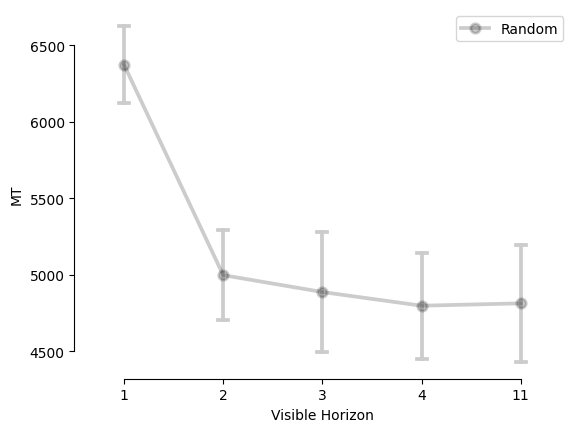

CPU times: user 16.4 s, sys: 314 ms, total: 16.7 s
Wall time: 16.9 s


In [92]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Random', capsize=0.1, **kwargs[label])




plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')
# plt.ylim([3000, 5500])

# legend labels

plt.legend(loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


### Motor influence only on the immediate item

<timed exec>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.021588e+08     4.0   2418.359912  0.000000
C(condition)                1.541736e+09     1.0  21240.059291  0.000000
C(windowSize):C(condition)  2.758000e+05     4.0      0.949904  0.434047
Residual                    1.444467e+08  1990.0           NaN       NaN


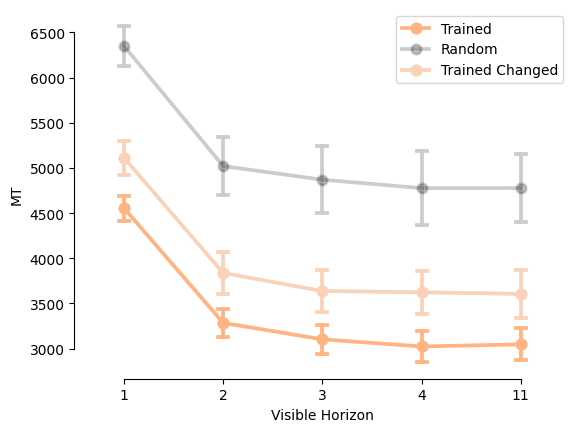

CPU times: user 40.7 s, sys: 1.17 s, total: 41.9 s
Wall time: 41.1 s


In [21]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


### memory influence on multiple items

In [63]:
motor_planning_param = [0.7527961,  0.78437558, 0.16115195]

<timed exec>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.818478e+08     4.0   2739.779399  0.000000
C(condition)                1.330633e+09     1.0  18651.416938  0.000000
C(windowSize):C(condition)  5.831406e+05     4.0      2.043463  0.085848
Residual                    1.419710e+08  1990.0           NaN       NaN


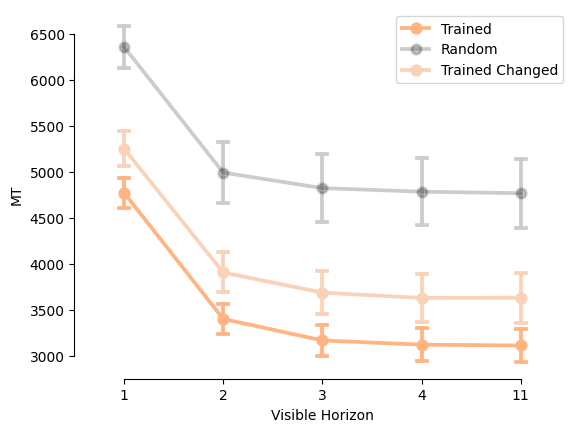

CPU times: user 44.8 s, sys: 1.63 s, total: 46.5 s
Wall time: 45.3 s


In [42]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


### Changing memory capacity with memory influence on the immediate item

In [74]:
memory_drift_coefs = [0.3, 0.5, 0.7, 1, 1.2, 1.5, 2, 2.5]
motor_planning_param = [1, 1, 0]

<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.3 ************************
                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.092496e+08     4.0   2421.576528  0.000000
C(condition)                1.583024e+09     1.0  21619.543178  0.000000
C(windowSize):C(condition)  3.994767e+05     4.0      1.363925  0.244073
Residual                    1.457115e+08  1990.0           NaN       NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.5 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               6.269971e+08     4.0   2529.173674  0.000000e+00
C(condition)                2.742318e+09     1.0  44247.725853  0.000000e+00
C(windowSize):C(condition)  5.803065e+06     4.0     23.408336  6.189517e-19
Residual                    1.233332e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.7 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               5.439866e+08     4.0   2058.786606  0.000000e+00
C(condition)                3.738846e+09     1.0  56600.565729  0.000000e+00
C(windowSize):C(condition)  1.370258e+07     4.0     51.859170  1.347146e-41
Residual                    1.314528e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               4.752939e+08     4.0   1835.161964  0.000000e+00
C(condition)                5.016674e+09     1.0  77479.720973  0.000000e+00
C(windowSize):C(condition)  2.741217e+07     4.0    105.841409  7.819855e-82
Residual                    1.288490e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.2 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               4.325690e+08     4.0   1716.078176   0.000000e+00
C(condition)                5.613632e+09     1.0  89081.101060   0.000000e+00
C(windowSize):C(condition)  3.528279e+07     4.0    139.973090  1.625406e-105
Residual                    1.254040e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.5 ************************
                                  sum_sq      df              F         PR(>F)
C(windowSize)               4.028605e+08     4.0    1730.116337   0.000000e+00
C(condition)                6.417608e+09     1.0  110243.705664   0.000000e+00
C(windowSize):C(condition)  5.302979e+07     4.0     227.740632  4.222520e-161
Residual                    1.158437e+08  1990.0            NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 2 ************************
                                  sum_sq      df              F         PR(>F)
C(windowSize)               3.560439e+08     4.0    1344.217218   0.000000e+00
C(condition)                7.477243e+09     1.0  112919.108354   0.000000e+00
C(windowSize):C(condition)  7.303507e+07     4.0     275.738508  9.737387e-189
Residual                    1.317732e+08  1990.0            NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 2.5 ************************
                                  sum_sq      df              F         PR(>F)
C(windowSize)               2.800414e+08     4.0    1155.081977   0.000000e+00
C(condition)                8.248179e+09     1.0  136084.518311   0.000000e+00
C(windowSize):C(condition)  1.307682e+08     4.0     539.377557  2.371971e-315
Residual                    1.206153e+08  1990.0            NaN            NaN
CPU times: user 5min 48s, sys: 22 s, total: 6min 10s
Wall time: 5min 55s


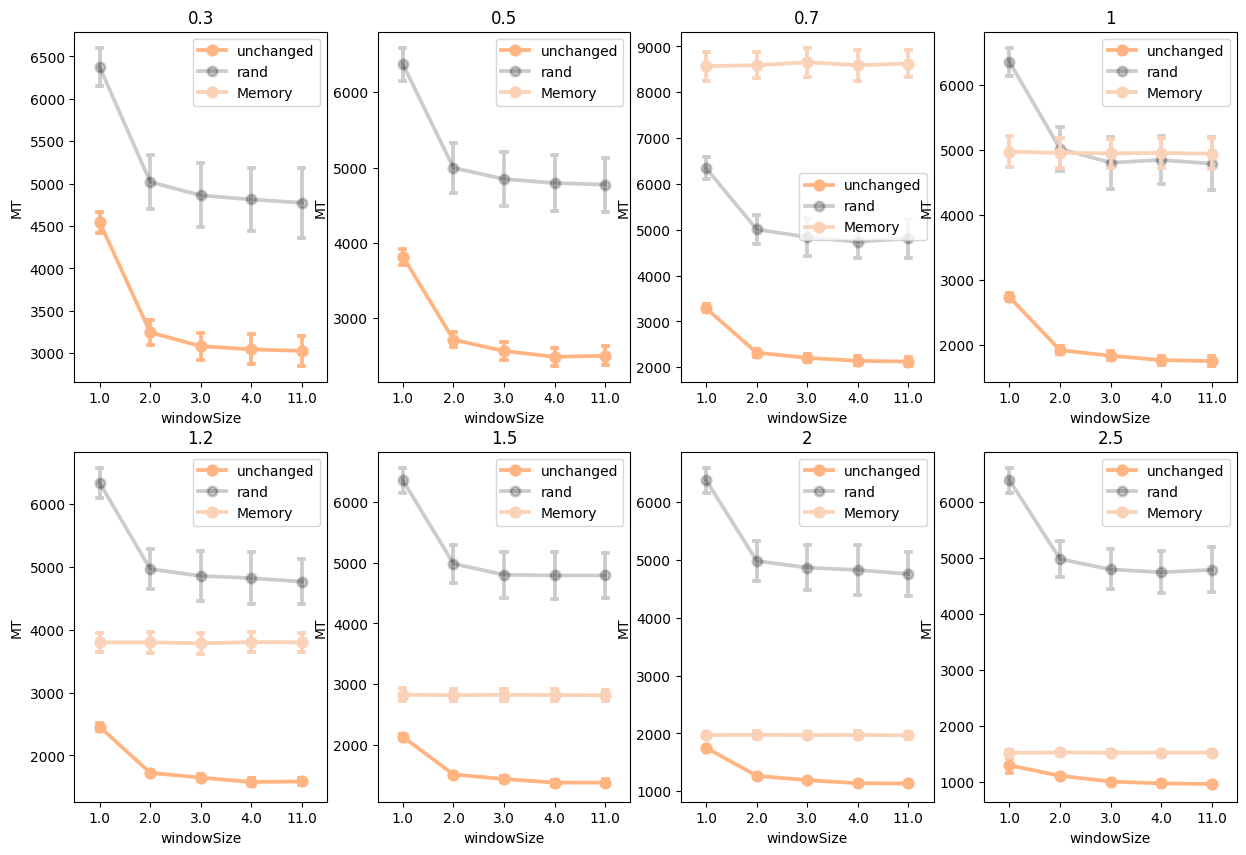

In [75]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'memory': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15,10))

for idx, memory_drift_coef in enumerate(memory_drift_coefs):
    plt_ind = (idx//4, idx%4)

    ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'memory'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, np.zeros((5, seq_length)), memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory', capsize=0.1, **kwargs[label], ax=axs[plt_ind])


    model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"***************** memory capacity = {memory_drift_coef} ************************")
    print(anova_table)

    axs[plt_ind].set_title(f"{memory_drift_coef}")


    # plt.xticks(range(len(window_sizes)), window_sizes)
    # plt.xlabel('Visible Horizon')
    # plt.ylabel('MT')

    # legend labels
    # handles, _ = plt.gca().get_legend_handles_labels()
    # labels = ['Trained', 'Random', 'Trained Changed']
    # plt.legend(handles, labels, loc='upper right')

    # plt.legend()
# sns.despine(trim=True)
    # plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
    # plt.show()


### Changing memory capacity with memory influence on the multiple item

In [76]:
memory_drift_coefs = [0.3, 0.5, 0.7, 1, 1.2, 1.5, 2, 2.5]
motor_planning_param = [0.7527961,  0.78437558, 0.16115195]

<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.3 ************************
                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.700222e+08     4.0   2785.442896  0.000000
C(condition)                1.329518e+09     1.0  19237.346020  0.000000
C(windowSize):C(condition)  4.644787e+05     4.0      1.680184  0.151867
Residual                    1.375315e+08  1990.0           NaN       NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.5 ************************
                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.167286e+08     4.0   2725.639272  0.000000
C(condition)                2.449258e+09     1.0  37257.019175  0.000000
C(windowSize):C(condition)  1.319355e+06     4.0      5.017361  0.000504
Residual                    1.308216e+08  1990.0           NaN       NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.7 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               6.425137e+08     4.0   2659.812380  0.000000e+00
C(condition)                3.510002e+09     1.0  58121.390271  0.000000e+00
C(windowSize):C(condition)  6.837467e+06     4.0     28.305046  6.689436e-23
Residual                    1.201779e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               5.434374e+08     4.0   2235.235759  0.000000e+00
C(condition)                4.739733e+09     1.0  77980.795468  0.000000e+00
C(windowSize):C(condition)  1.726979e+07     4.0     71.033121  2.661555e-56
Residual                    1.209537e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.2 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               4.944859e+08     4.0   1968.410575  0.000000e+00
C(condition)                5.406225e+09     1.0  86082.694228  0.000000e+00
C(windowSize):C(condition)  2.480501e+07     4.0     98.741835  9.623142e-77
Residual                    1.249774e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.5 ************************
                                  sum_sq      df              F         PR(>F)
C(windowSize)               4.420564e+08     4.0    1824.176933   0.000000e+00
C(condition)                6.340930e+09     1.0  104665.176588   0.000000e+00
C(windowSize):C(condition)  3.801422e+07     4.0     156.868343  8.816646e-117
Residual                    1.205602e+08  1990.0            NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 2 ************************
                                  sum_sq      df              F         PR(>F)
C(windowSize)               3.686252e+08     4.0    1565.297866   0.000000e+00
C(condition)                7.295665e+09     1.0  123918.717213   0.000000e+00
C(windowSize):C(condition)  5.443066e+07     4.0     231.129608  4.124626e-163
Residual                    1.171605e+08  1990.0            NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 2.5 ************************
                                  sum_sq      df              F         PR(>F)
C(windowSize)               3.068571e+08     4.0    1309.276360   0.000000e+00
C(condition)                8.192274e+09     1.0  139816.873873   0.000000e+00
C(windowSize):C(condition)  9.510372e+07     4.0     405.781884  8.245155e-256
Residual                    1.165998e+08  1990.0            NaN            NaN
CPU times: user 6min 2s, sys: 20 s, total: 6min 23s
Wall time: 6min 8s


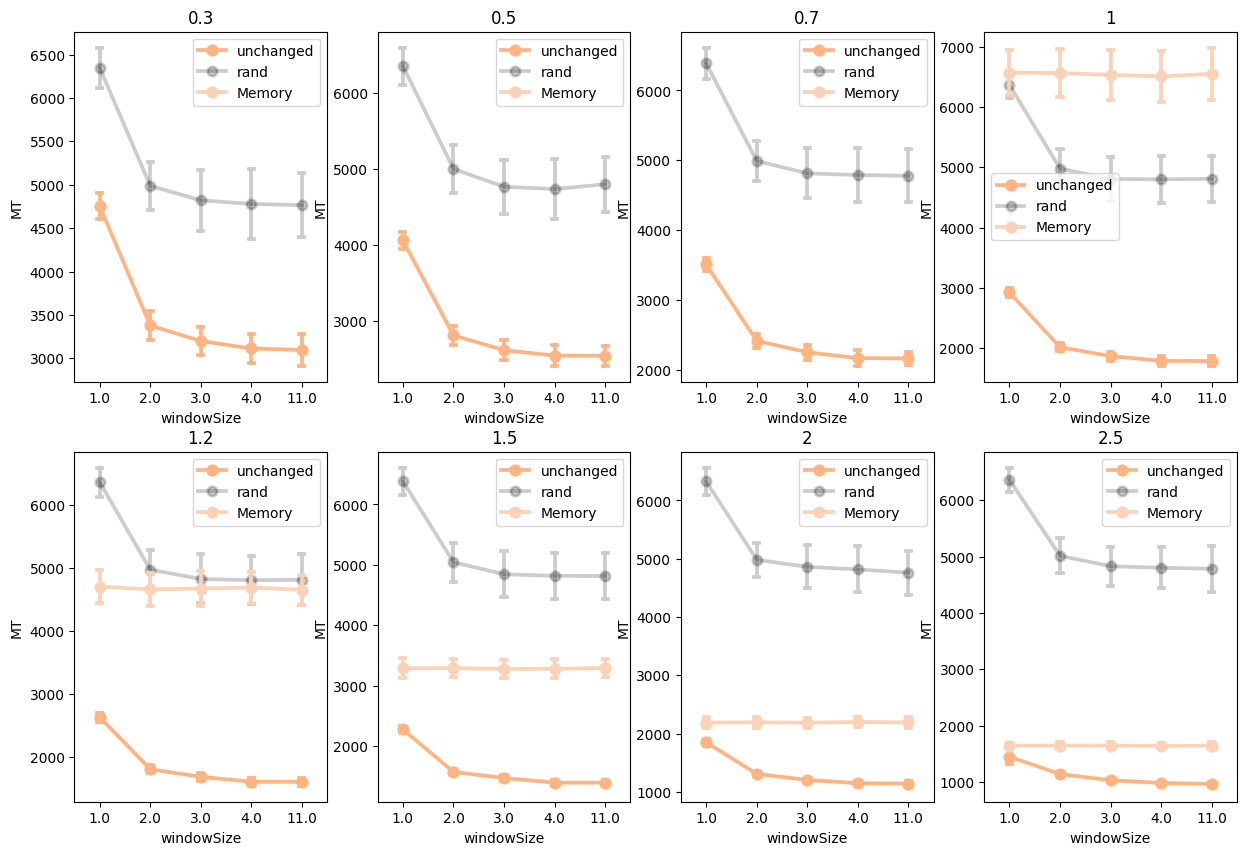

In [77]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'memory': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15,10))

for idx, memory_drift_coef in enumerate(memory_drift_coefs):
    plt_ind = (idx//4, idx%4)

    ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]



    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'memory'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, np.zeros((5, seq_length)), memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory', capsize=0.1, **kwargs[label], ax=axs[plt_ind])


    model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"***************** memory capacity = {memory_drift_coef} ************************")
    print(anova_table)

    axs[plt_ind].set_title(f"{memory_drift_coef}")


    # plt.xticks(range(len(window_sizes)), window_sizes)
    # plt.xlabel('Visible Horizon')
    # plt.ylabel('MT')

    # legend labels
    # handles, _ = plt.gca().get_legend_handles_labels()
    # labels = ['Trained', 'Random', 'Trained Changed']
    # plt.legend(handles, labels, loc='upper right')

    # plt.legend()
# sns.despine(trim=True)
    # plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
    # plt.show()


### Changing memory capacity and visual capcity at the same time with memory influence on the immediate item

In [110]:
max_capacity = 1.8
memory_drift_coefs = [0.3, 0.5, 0.7, 1, 1.2, 1.5, 2, 2.5]
memory_drift_coefs = [min(max_capacity, coef) for coef in memory_drift_coefs]
visual_drift_coefs = [(max_capacity - memory_coef)/1.5 for memory_coef in memory_drift_coefs]
motor_planning_param = [1, 1, 0]


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.3 ************************
                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.137478e+08     4.0   2323.652142  0.000000
C(condition)                1.530541e+09     1.0  19931.106528  0.000000
C(windowSize):C(condition)  1.137894e+06     4.0      3.704488  0.005202
Residual                    1.528153e+08  1990.0           NaN       NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.5 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               5.782684e+08     4.0   1936.359595  0.000000e+00
C(condition)                1.912195e+09     1.0  25612.316477  0.000000e+00
C(windowSize):C(condition)  8.896313e+06     4.0     29.789736  4.241768e-24
Residual                    1.485718e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.7 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               4.811899e+08     4.0   1770.644379  0.000000e+00
C(condition)                2.282600e+09     1.0  33597.326618  0.000000e+00
C(windowSize):C(condition)  2.734008e+07     4.0    100.603844  4.391948e-78
Residual                    1.352005e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               3.648922e+08     4.0   1384.687465   0.000000e+00
C(condition)                2.764795e+09     1.0  41967.215475   0.000000e+00
C(windowSize):C(condition)  6.129341e+07     4.0    232.595339  5.608598e-164
Residual                    1.311010e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.2 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               3.116467e+08     4.0   1305.644334   0.000000e+00
C(condition)                3.100456e+09     1.0  51957.454740   0.000000e+00
C(windowSize):C(condition)  1.005874e+08     4.0    421.410825  3.253305e-263
Residual                    1.187492e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.5 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               2.238219e+08     4.0    920.723633   0.000000e+00
C(condition)                3.696698e+09     1.0  60827.607290   0.000000e+00
C(windowSize):C(condition)  1.349238e+08     4.0    555.028564  8.053270e-322
Residual                    1.209390e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.8 ************************
                                  sum_sq      df             F  PR(>F)
C(windowSize)               1.846920e+08     4.0    785.342349     0.0
C(condition)                4.275710e+09     1.0  72724.245431     0.0
C(windowSize):C(condition)  1.835306e+08     4.0    780.404234     0.0
Residual                    1.169990e+08  1990.0           NaN     NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.8 ************************
                                  sum_sq      df             F  PR(>F)
C(windowSize)               1.852402e+08     4.0    761.467348     0.0
C(condition)                4.197649e+09     1.0  69021.126439     0.0
C(windowSize):C(condition)  1.865666e+08     4.0    766.919424     0.0
Residual                    1.210256e+08  1990.0           NaN     NaN
CPU times: user 6min 6s, sys: 21.3 s, total: 6min 27s
Wall time: 6min 12s


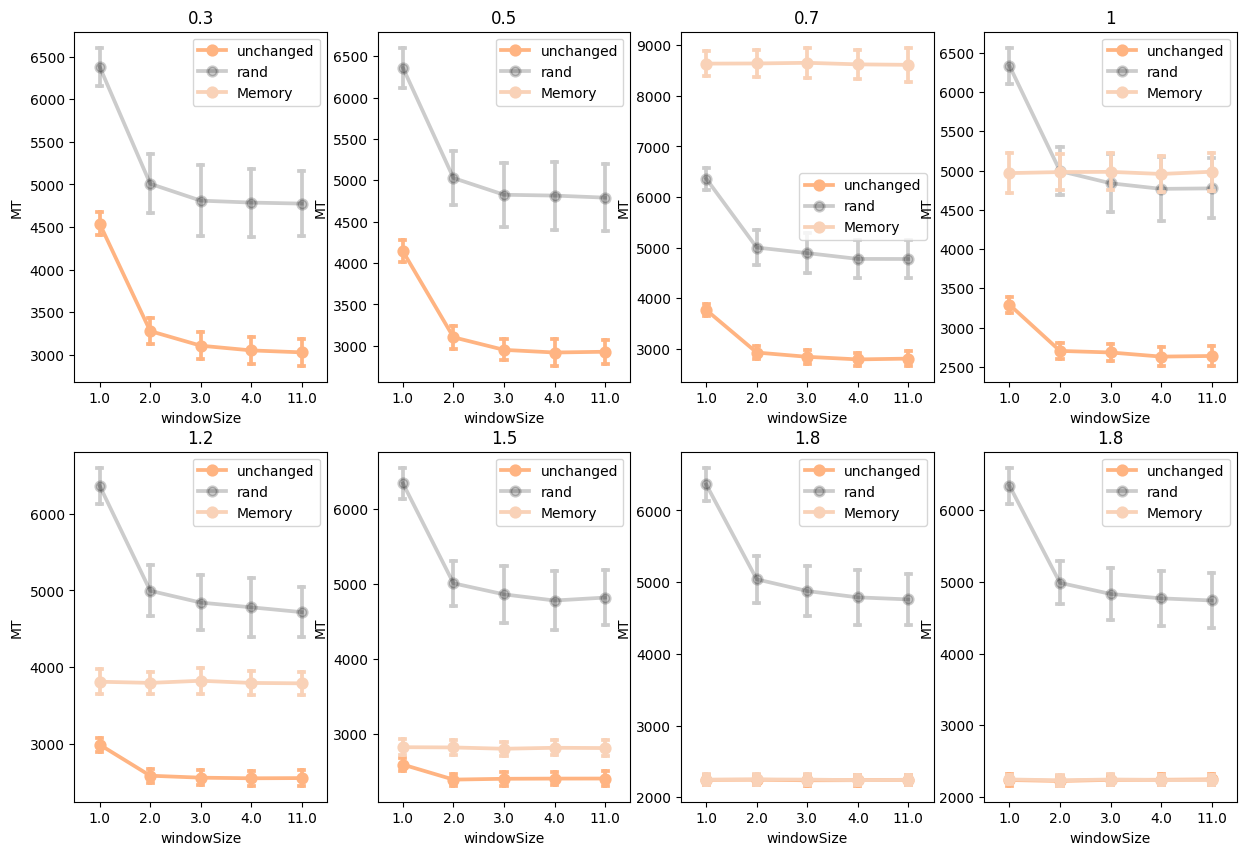

In [116]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'memory': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15,10))

for idx, memory_drift_coef in enumerate(memory_drift_coefs):
    plt_ind = (idx//4, idx%4)

    ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef, visual_drift_coef = visual_drift_coefs[idx])
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, 
        memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'memory'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, np.zeros((5, seq_length)), memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef, visual_drift_coef = visual_drift_coefs[idx])
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory', capsize=0.1, **kwargs[label], ax=axs[plt_ind])


    model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"***************** memory capacity = {memory_drift_coef} ************************")
    print(anova_table)

    axs[plt_ind].set_title(f"{memory_drift_coef}")


    # plt.xticks(range(len(window_sizes)), window_sizes)
    # plt.xlabel('Visible Horizon')
    # plt.ylabel('MT')

    # legend labels
    # handles, _ = plt.gca().get_legend_handles_labels()
    # labels = ['Trained', 'Random', 'Trained Changed']
    # plt.legend(handles, labels, loc='upper right')

    # plt.legend()
# sns.despine(trim=True)
    # plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
    # plt.show()


### Changing memory capacity and visual capcity at the same time with memory influence on the multiple item

In [117]:
max_capacity = 1.8
memory_drift_coefs = [0.3, 0.5, 0.7, 1, 1.2, 1.5, 2, 2.5]
memory_drift_coefs = [min(max_capacity, coef) for coef in memory_drift_coefs]
visual_drift_coefs = [(max_capacity - memory_coef)/1.5 for memory_coef in memory_drift_coefs]
motor_planning_param = [0.7527961,  0.78437558, 0.16115195]



<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.3 ************************
                                  sum_sq      df             F    PR(>F)
C(windowSize)               7.720441e+08     4.0   2695.784529  0.000000
C(condition)                1.381464e+09     1.0  19294.909550  0.000000
C(windowSize):C(condition)  8.224094e+05     4.0      2.871648  0.021859
Residual                    1.424787e+08  1990.0           NaN       NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.5 ************************
                                  sum_sq      df             F    PR(>F)
C(windowSize)               6.785330e+08     4.0   2210.384803  0.000000
C(condition)                1.625430e+09     1.0  21179.957258  0.000000
C(windowSize):C(condition)  2.415729e+06     4.0      7.869463  0.000003
Residual                    1.527201e+08  1990.0           NaN       NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 0.7 ************************
                                  sum_sq      df             F        PR(>F)
C(windowSize)               5.717461e+08     4.0   1956.177021  0.000000e+00
C(condition)                1.867589e+09     1.0  25559.145910  0.000000e+00
C(windowSize):C(condition)  9.047272e+06     4.0     30.954415  4.892751e-25
Residual                    1.454079e+08  1990.0           NaN           NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               4.311518e+08     4.0   1548.082073   0.000000e+00
C(condition)                2.301407e+09     1.0  33053.484302   0.000000e+00
C(windowSize):C(condition)  3.816926e+07     4.0    137.049522  1.549449e-103
Residual                    1.385573e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.2 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               3.578715e+08     4.0   1352.067110   0.000000e+00
C(condition)                2.607047e+09     1.0  39398.523519   0.000000e+00
C(windowSize):C(condition)  7.056891e+07     4.0    266.614972  1.282336e-183
Residual                    1.316807e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.5 ************************
                                  sum_sq      df             F         PR(>F)
C(windowSize)               2.512799e+08     4.0    946.093458   0.000000e+00
C(condition)                3.074672e+09     1.0  46305.754655   0.000000e+00
C(windowSize):C(condition)  1.166366e+08     4.0    439.148208  1.820889e-271
Residual                    1.321347e+08  1990.0           NaN            NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.8 ************************
                                  sum_sq      df             F  PR(>F)
C(windowSize)               1.888382e+08     4.0    712.916692     0.0
C(condition)                3.494155e+09     1.0  52765.605166     0.0
C(windowSize):C(condition)  1.873825e+08     4.0    707.420736     0.0
Residual                    1.317784e+08  1990.0           NaN     NaN


<timed exec>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


***************** memory capacity = 1.8 ************************
                                  sum_sq      df             F  PR(>F)
C(windowSize)               1.823888e+08     4.0    662.109595     0.0
C(condition)                3.448054e+09     1.0  50068.622282     0.0
C(windowSize):C(condition)  1.775741e+08     4.0    644.631296     0.0
Residual                    1.370444e+08  1990.0           NaN     NaN
CPU times: user 6min 16s, sys: 21.3 s, total: 6min 38s
Wall time: 6min 22s


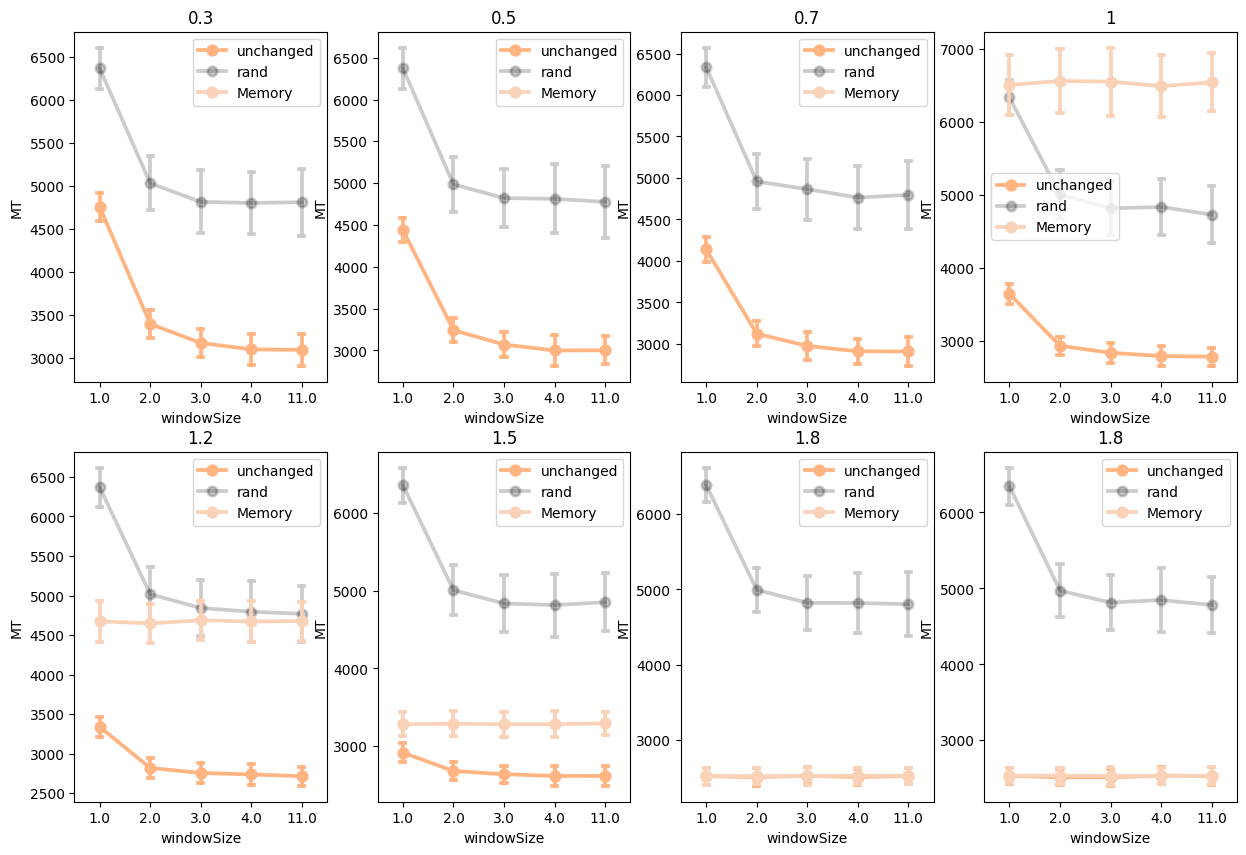

In [118]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'memory': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15,10))

for idx, memory_drift_coef in enumerate(memory_drift_coefs):
    plt_ind = (idx//4, idx%4)

    ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef, visual_drift_coef = visual_drift_coefs[idx])
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, 
        memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label], ax=axs[plt_ind])

    ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'memory'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, np.zeros((5, seq_length)), memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef, visual_drift_coef = visual_drift_coefs[idx])
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory', capsize=0.1, **kwargs[label], ax=axs[plt_ind])


    model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"***************** memory capacity = {memory_drift_coef} ************************")
    print(anova_table)

    axs[plt_ind].set_title(f"{memory_drift_coef}")


    # plt.xticks(range(len(window_sizes)), window_sizes)
    # plt.xlabel('Visible Horizon')
    # plt.ylabel('MT')

    # legend labels
    # handles, _ = plt.gca().get_legend_handles_labels()
    # labels = ['Trained', 'Random', 'Trained Changed']
    # plt.legend(handles, labels, loc='upper right')

    # plt.legend()
# sns.despine(trim=True)
    # plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
    # plt.show()
